In [1]:
import time
import pandas as pd
import numpy as np
from cuml.preprocessing import StandardScaler as cuScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Load the dataset of computed Barrier Option Prices
file_path = 'barriers_v2_100K.zip'
data = pd.read_csv(file_path, compression='zip')

In [3]:
# Prepare the features and target variable
X = data[['Strike', 'Barrier', 'Maturity', 'Spot', 'Rate', 'Volatility', 'BarrierType', 'ExerciseType', 'OptionType']]
y = data['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using cuML scaler for GPU acceleration
scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Train and evaluate GPU-accelerated Gradient Boosting model using XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {
    'max_depth': 20,  # The depth of the tree has a significant affect on model accuracy
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': "cuda"
}
start_time = time.time()  # Time how long is takes to train the model
gbdt_model = xgb.train(params, dtrain, num_boost_round=100)
elapsed_time = time.time() - start_time
print(f"Time to train Barrier Option GBDT model : {elapsed_time} seconds")

start_time = time.time()  # Time how long is take to make the predictions
y_pred_gbdt = gbdt_model.predict(dtest)
elapsed_time = time.time() - start_time
predictions_per_second = len(y_pred_gbdt) / elapsed_time
print(f"Barrier Option predictions per second: {predictions_per_second}")

Time to train Barrier Option GBDT model : 35.13524675369263 seconds
Barrier Option predictions per second: 444311.86440677964


In [5]:
# Evaluate models - Now filtered to just GBDT as Random Forest an SVM performed porrly
models = {'GBDT': y_pred_gbdt}

In [6]:
for model_name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))  # Mean Absolute Error
    epsilon = 1e-10  # Small value to avoid division by zero
    y_test_non_zero = y_test[y_test > epsilon]
    y_pred_non_zero = y_pred[y_test > epsilon]
    mape = np.mean(np.abs((y_test_non_zero - y_pred_non_zero) / np.maximum(y_test_non_zero, epsilon))) * 100  # Mean Absolute Percentage Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    print(f"{model_name} Model")
    print(f"Mean Squared Error: {mse}, R^2 Score: {r2}, Mean Absolute Error: {mae}") 
    print(f"Mean Absolute Percentage Error: {mape}%, Root Mean Squared Error: {rmse}")

GBDT Model
Mean Squared Error: 113236.49958586268, R^2 Score: 0.9790263220249963, Mean Absolute Error: 116.0173062340498
Mean Absolute Percentage Error: 760823.2712701416%, Root Mean Squared Error: 336.506314332826


In [7]:
# In order to avoid running out of memory when plotting results we only show the first N
max_plot = 10000

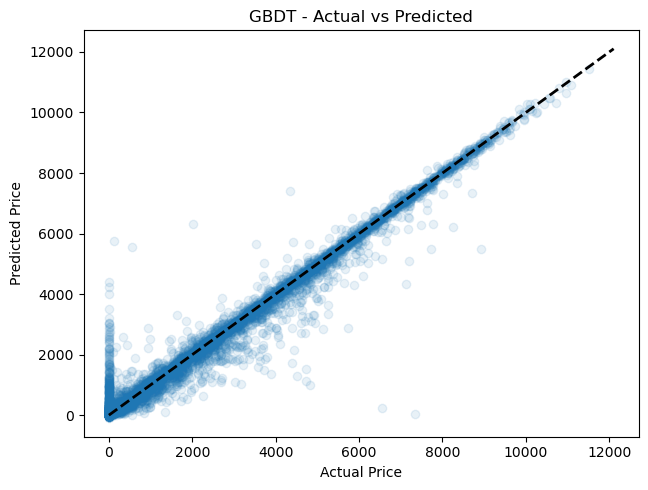

In [8]:
# Simple initial plot of the actual vs predicted values for the model using Matplotlib
plt.figure(figsize=(18, 5))
for i, (model_name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test[:max_plot], y_pred[:max_plot], alpha=0.1)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Actual vs Predicted')

plt.tight_layout()
plt.show()

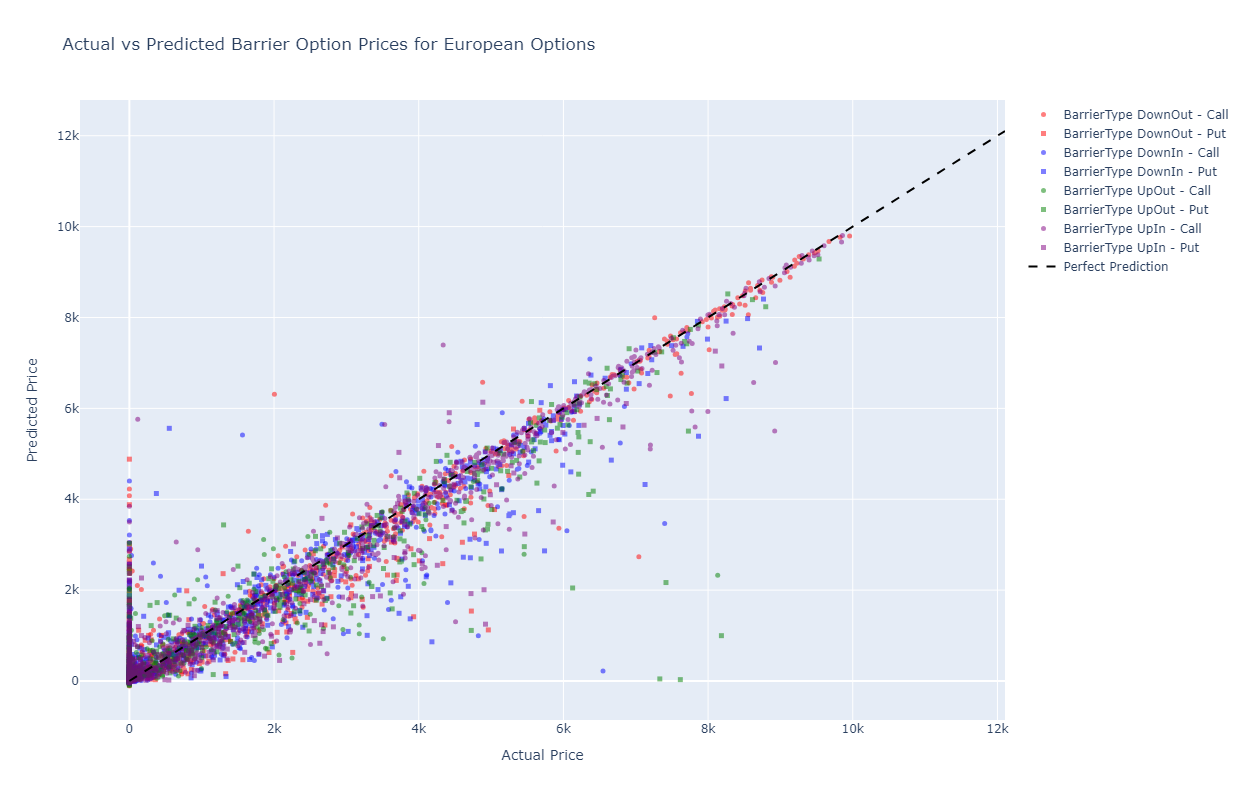

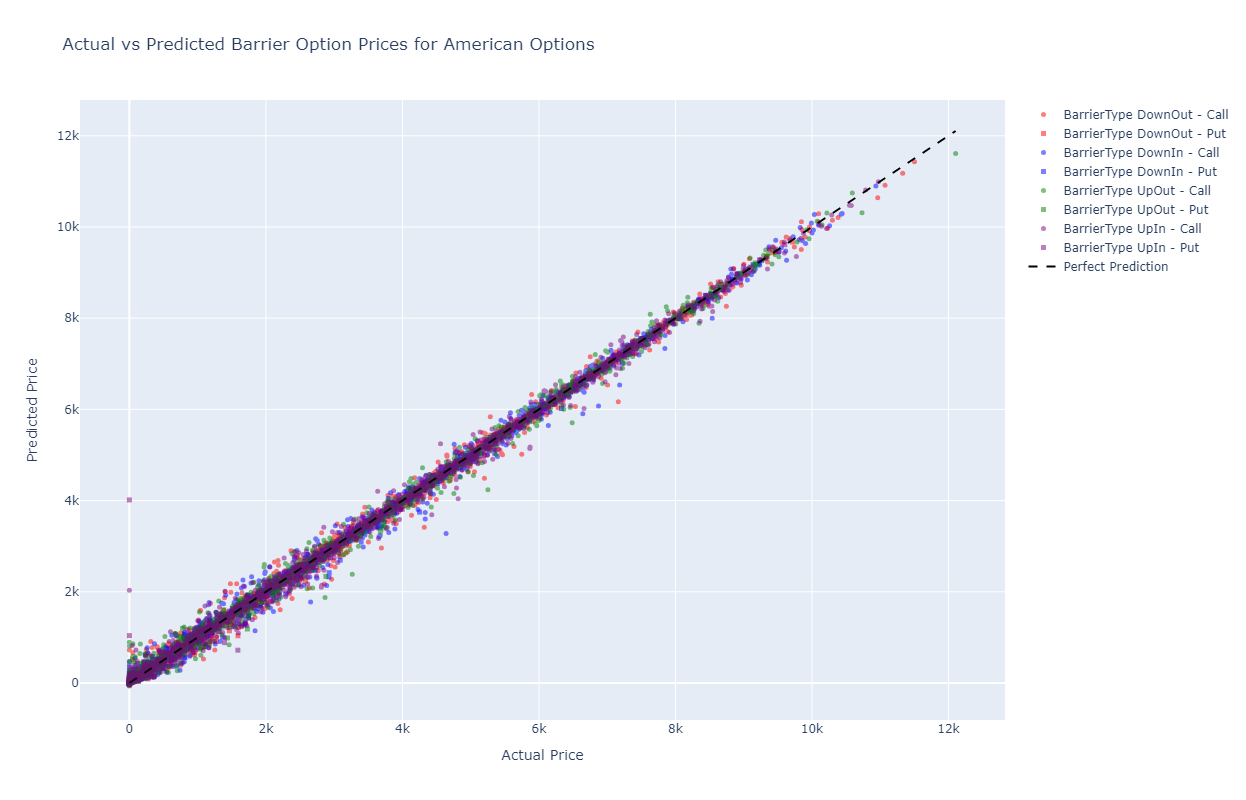

In [9]:
# Plot the actual vs predicted values for each model using Plotly, color by BarrierType and OptionType
# Plotly is used for more advanceed plotting and for abilty to be inserted into Dash dashboards

barrier_types = X_test['BarrierType'].unique()
option_types = X_test['OptionType'].unique()
barrier_colors = ['red', 'blue', 'green', 'purple']
option_markers = ['circle', 'square']

# Plot for European Options
european_mask = X_test['ExerciseType'] == 0
fig_european = go.Figure()

for barrier_type, barrier_color in zip(barrier_types, barrier_colors):
    for option_type, option_marker in zip(option_types, option_markers):
        combined_mask = (X_test['BarrierType'] == barrier_type) & (X_test['OptionType'] == option_type) & european_mask
        for model_name, y_pred in models.items():
            fig_european.add_trace(go.Scatter(
                x=y_test[combined_mask][:max_plot],
                y=y_pred[combined_mask][:max_plot],
                mode='markers',
                name=f'BarrierType {["DownIn", "DownOut", "UpIn", "UpOut"][barrier_type]} - {["Call", "Put"][option_type]}',
                opacity=0.5,
                marker=dict(size=5, color=barrier_color, symbol=option_marker)
            ))

fig_european.add_trace(go.Scatter(
    x=[y.min(), y.max()],
    y=[y.min(), y.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(dash='dash', color='black')
))
fig_european.update_layout(
    title='Actual vs Predicted Barrier Option Prices for European Options',
    xaxis_title='Actual Price',
    yaxis_title='Predicted Price',
    showlegend=True,
    autosize=False,
    width=1200,
    height=800,
)
fig_european.show()

# Plot for American Options
american_mask = X_test['ExerciseType'] == 1
fig_american = go.Figure()

for barrier_type, barrier_color in zip(barrier_types, barrier_colors):
    for option_type, option_marker in zip(option_types, option_markers):
        combined_mask = (X_test['BarrierType'] == barrier_type) & (X_test['OptionType'] == option_type) & american_mask
        for model_name, y_pred in models.items():
            fig_american.add_trace(go.Scatter(
                x=y_test[combined_mask][:max_plot],
                y=y_pred[combined_mask][:max_plot],
                mode='markers',
                name=f'BarrierType {["DownIn", "DownOut", "UpIn", "UpOut"][barrier_type]} - {["Call", "Put"][option_type]}',
                opacity=0.5,
                marker=dict(size=5, color=barrier_color, symbol=option_marker)
            ))

fig_american.add_trace(go.Scatter(
    x=[y.min(), y.max()],
    y=[y.min(), y.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(dash='dash', color='black')
))
fig_american.update_layout(
    title='Actual vs Predicted Barrier Option Prices for American Options',
    xaxis_title='Actual Price',
    yaxis_title='Predicted Price',
    showlegend=True,
    autosize=False,
    width=1200,
    height=800,
)
fig_american.show()

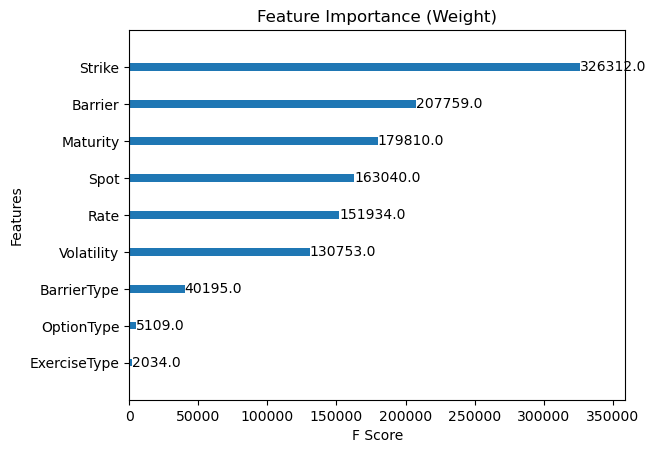

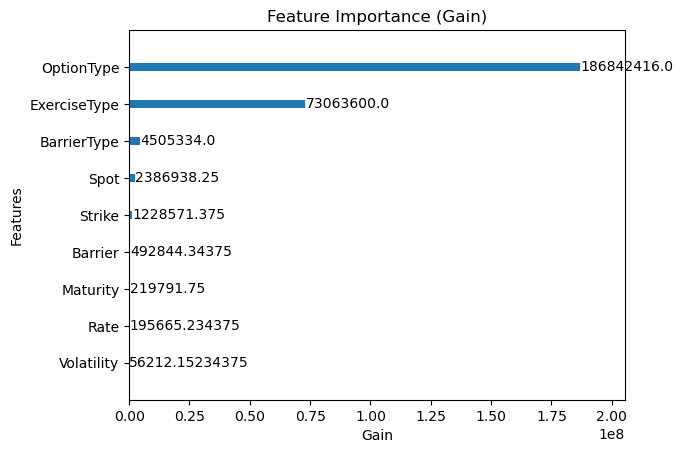

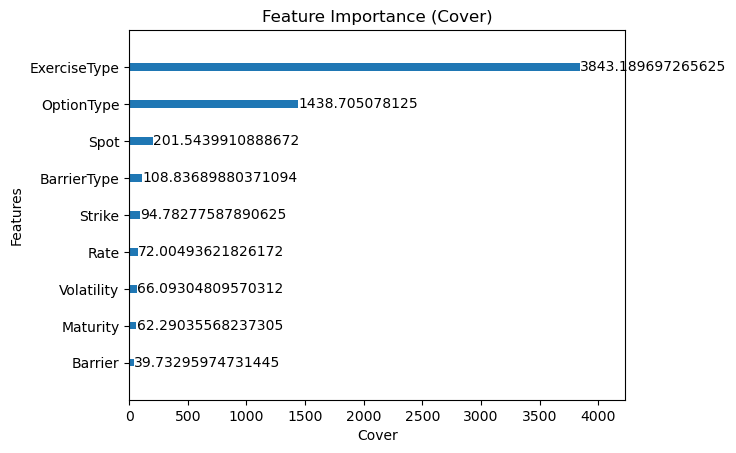

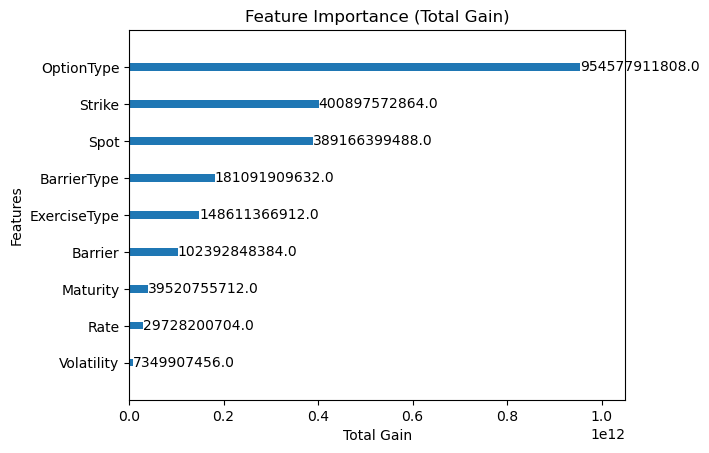

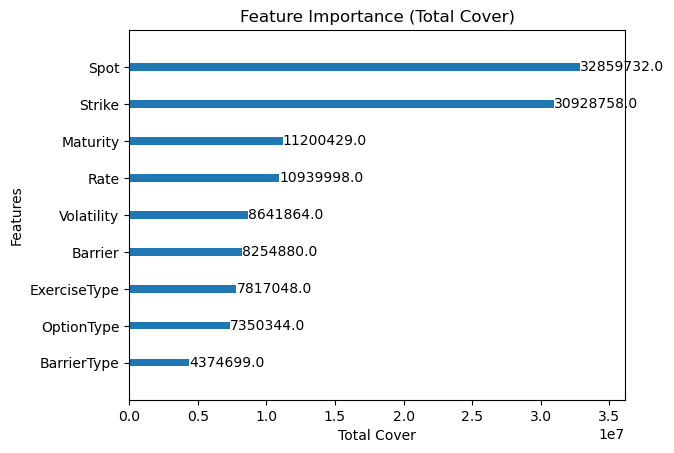

In [12]:
# Plot feature importance for the XGBoost model
# Gain: The average gain of splits which use the feature.
# Cover: The number of observation samples that fall into splits using the feature.
# Total Gain: The sum of gain across all splits which use the feature.
# Total Cover: The sum of cover across all splits which use the feature.
import matplotlib.pyplot as plt

# Feature Importance by Weight
xgb.plot_importance(gbdt_model, importance_type='weight', title='Feature Importance (Weight)', xlabel='F Score', ylabel='Features', grid=False)
plt.show()

# Feature Importance by Gain
xgb.plot_importance(gbdt_model, importance_type='gain', title='Feature Importance (Gain)', xlabel='Gain', ylabel='Features', grid=False)
plt.show()

# Feature Importance by Cover
xgb.plot_importance(gbdt_model, importance_type='cover', title='Feature Importance (Cover)', xlabel='Cover', ylabel='Features', grid=False)
plt.show()

# Feature Importance by Total Gain
xgb.plot_importance(gbdt_model, importance_type='total_gain', title='Feature Importance (Total Gain)', xlabel='Total Gain', ylabel='Features', grid=False)
plt.show()

# Feature Importance by Total Cover
xgb.plot_importance(gbdt_model, importance_type='total_cover', title='Feature Importance (Total Cover)', xlabel='Total Cover', ylabel='Features', grid=False)
plt.show()
y_pred_gbdt = gbdt_model.predict(dtest)
